# Stock price forecasting with a Transformer model

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta

## Download data (Apple 2005-2024)

### Data acquisition and preparation

In [2]:
data = yf.download("AAPL", start="2010-01-01", end="2023-01-01")
data = data[['Close']].rename(columns={'Close': 'Price'})


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Calcul des rendements logarithmiques (plus stationnaires)
data['Return'] = np.log(data['Price']) - np.log(data['Price'].shift(1))
data = data.dropna()

In [4]:
data

Price,Price,Return
Ticker,AAPL,
Date,,
2010-01-05,6.443017,0.001727
2010-01-06,6.340532,-0.016034
2010-01-07,6.328810,-0.001850
2010-01-08,6.370885,0.006626
2010-01-11,6.314686,-0.008860
...,...,...
2022-12-23,130.173782,-0.002802
2022-12-27,128.367203,-0.013975


In [5]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

# Split training, validation and testing data (70% train, 20% validation, 10% test)

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size+val_size]
test_data = data.iloc[train_size+val_size:]

In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data['Return_scaled'] = scaler.fit_transform(train_data[['Return']])
val_data['Return_scaled'] = scaler.transform(val_data[['Return']])
test_data['Return_scaled'] = scaler.transform(test_data[['Return']])

/var/folders/0j/ljklzk2x25zff3_dbl9d8l0m0000gn/T/ipykernel_75374/3999966029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Return_scaled'] = scaler.fit_transform(train_data[['Return']])
/var/folders/0j/ljklzk2x25zff3_dbl9d8l0m0000gn/T/ipykernel_75374/3999966029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['Return_scaled'] = scaler.transform(val_data[['Return']])
/var/folders/0j/ljklzk2x25zff3_dbl9d8l0m0000gn/T/ipykernel_75374/3999966029.py:5: SettingWithCopyWarning: 
A value

In [7]:
# Temporal sequence data preparation
def create_sequences(data, seq_length=90, target_col='Return_scaled'):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length - 1):
        seq = data[target_col].iloc[i:i+seq_length].values
        label = data[target_col].iloc[i+seq_length+1]  # Next value after the sequence (t+1)
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [8]:
SEQ_LENGTH = 300

# Split into sequences and labels
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_val, y_val = create_sequences(val_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Add channel dimension
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val).unsqueeze(-1)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test).unsqueeze(-1)  # Add channel dimension
y_test = torch.FloatTensor(y_test)

# Save the data
torch.save((X_train, y_train), './Data/train_data.pt')
torch.save((X_val, y_val), './Data/val_data.pt')
torch.save((X_test, y_test), './Data/test_data.pt')
torch.save(scaler, './Data/scaler.pt')

## Transformer Architecture

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout) # Dropout layer for regularization

        position = torch.arange(max_len).unsqueeze(1) # Create a position tensor
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model)) # Calculate the division term for positional encoding
        pe = torch.zeros(max_len, 1, d_model) # Initialize positional encoding tensor
        pe[:, 0, 0::2] = torch.sin(position * div_term) # Apply sine function to even indices
        pe[:, 0, 1::2] = torch.cos(position * div_term) # Apply cosine function to odd indices
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0)] # Use sequence length: x.size(0) is for the sequence length and x.size(1) is for the batch size
        return self.dropout(x).permute(1, 0, 2)

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, num_layers, hidden_dim, nhead, dropout=0.1):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_dim) # Input projection which linearizes the input
        self.pos_enoder = PositionalEncoding(hidden_dim, dropout) # Positional encoding to add temporal information
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dropout=dropout,
            batch_first=True,
            dim_feedforward=hidden_dim*4  # Add a feedforward layer with 4 times the hidden dimension
        ) # Transformer encoder layer

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        ) # Final transformer encoder which uses the encoder layer to process the input data and number of layers
        
        self.decoder = nn.Linear(hidden_dim, 1) # Final linear layer to output the prediction
    
    def forward(self, src):
        src = self.encoder(src) # Project input to hidden dimension
        src = self.pos_enoder(src) # Add positional encoding to the input
        output = self.transformer(src) # Pass through the transformer encoder
        output = self.decoder(output[:, -1, :])  # Take the last output for prediction
        return output.squeeze()

## Model training

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

(torch.Size([1988, 300, 1]),
 torch.Size([1988]),
 torch.Size([27, 300, 1]),
 torch.Size([27]),
 torch.Size([353, 300, 1]),
 torch.Size([353]))

In [11]:
# Hyperparameters
INPUT_SIZE = 1  # Single feature (Price)
NUM_LAYERS = 4  # Number of transformer layers
HIDDEN_DIM = 128  # Hidden dimension size
NHEAD = 8  # Number of attention heads. Because nhead must divide hidden_dim, we choose 8 for 128
DROPOUT = 0.3  # Dropout rate
LR = 0.0001  # Learning rate
EPOCHS = 50  # Number of training epochs
BATCH_SIZE = 64  # Batch size   

In [12]:
# Load the training data and test data
# X_train, y_train = torch.load('./Data/train_data.pt')
# X_test, y_test = torch.load('./Data/test_data.pt')

# Initialize the model, loss function, and optimizer
model = TimeSeriesTransformer(
    INPUT_SIZE,
    NUM_LAYERS,
    HIDDEN_DIM,
    NHEAD,
    DROPOUT)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5) # Reduce learning rate when a metric has stopped improving


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)  # Create a dataset for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)  # DataLoader for batching


# Early stopping
best_val_loss = float('inf')
patience = 10
counter = 0

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)  # Forward pass
        loss = criterion(output, batch_y)  # Compute loss
        loss.backward()  # Backward pass

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip gradients to prevent exploding gradients

        optimizer.step()  # Update weights
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val).item()
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), './models/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.6f}, Val Loss: {val_loss:.6f}')


Epoch 10, Train Loss: 0.026915, Val Loss: 0.033992
Epoch 20, Train Loss: 0.025454, Val Loss: 0.033988
Early stopping at epoch 30


## Evaluation and prediction on test data

In [24]:
model.load_state_dict(torch.load('./models/best_model.pth'))

<All keys matched successfully>

In [25]:
# print the info of the model
print(model)

TimeSeriesTransformer(
  (encoder): Linear(in_features=1, out_features=128, bias=True)
  (pos_enoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)


In [26]:
with torch.no_grad():
    test_pred = model(X_test)
    test_loss = criterion(test_pred, y_test).item()

# Conversion inverse des rendements
test_pred_returns = scaler.inverse_transform(test_pred.numpy().reshape(-1, 1))
y_test_returns = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Conversion en prix
test_prices = test_data['Price'].iloc[SEQ_LENGTH+1:].values.reshape(-1, 1)
test_pred_prices = test_prices * np.exp(test_pred_returns)

In [16]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
mae = mean_absolute_error(test_prices, test_pred_prices)
rmse = np.sqrt(mean_squared_error(test_prices, test_pred_prices))
mape = calculate_mape(test_prices, test_pred_prices)

print("\nTest Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Test Performance:
MAE: 0.30
RMSE: 0.30
MAPE: 0.22%


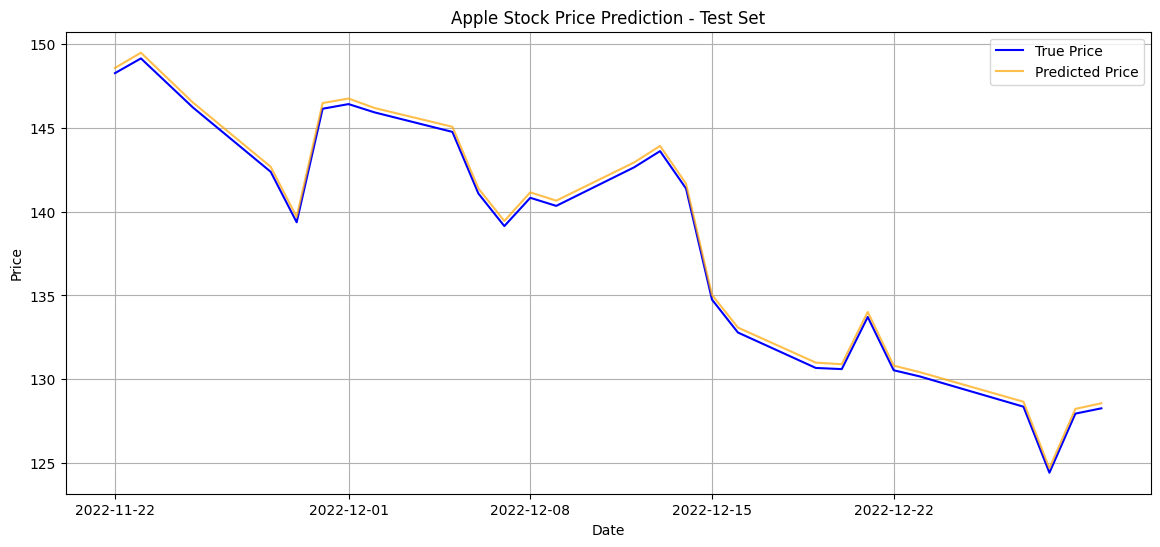

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(test_data.index[SEQ_LENGTH+1:], test_prices, label='True Price', color='blue')
plt.plot(test_data.index[SEQ_LENGTH+1:], test_pred_prices, label='Predicted Price', color='orange', alpha=0.7)
plt.title('Apple Stock Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# def generate_future_predictions(model, scaler, last_sequence, sequence_length, n_future_days, data):

#     model.eval()
#     current_sequence = last_sequence.copy()
#     future_returns = []

#     # Generate future returns iteratively
#     for _ in range(n_future_days):
#         # Prepare input sequence
#         seq_normalized = scaler.transform(current_sequence[-sequence_length:].reshape(-1, 1))
#         seq_tensor = torch.FloatTensor(seq_normalized).unsqueeze(0)  # (1, seq_len, 1)
        
#         with torch.no_grad():
#             pred_return_normalized = model(seq_tensor).item()

#         pred_return = scaler.inverse_transform(np.array([[pred_return_normalized]]))[0, 0]
#         future_returns.append(pred_return)

#         # Update the sequence with the new prediction
#         new_price = current_sequence[-1] * np.exp(pred_return)  # Convert return to price
#         if type(new_price) is not float:
#             new_price = new_price.item()
#         current_sequence = np.append(current_sequence, new_price)
        

#     # Converting yields into prices
#     last_known_price = last_sequence[-1]
#     future_prices = [last_known_price * np.exp(sum(future_returns[:i+1])) for i in range(len(future_returns))]
#     print("Future prices", future_prices)

#     last_date = data.index[-1]
#     future_dates = [last_date + timedelta(days=i) for i in range(1, n_future_days+1)]

#     return future_dates, future_prices


In [28]:
def generate_future_predictions(model, scaler, last_sequence, sequence_length, n_future_days, data):
    """
    Generates future predictions for stock prices based on a trained model.

    Args:
        model: Trained PyTorch model.
        scaler: Scaler used for normalizing the data.
        last_sequence: Last known sequence of prices (numpy array).
        sequence_length: Length of the input sequences used during training.
        n_future_days: Number of future days to predict.
        data: Historical data (Pandas DataFrame) for reference.

    Returns:
        future_dates: List of future dates.
        future_prices: List of predicted future prices.
    """
    model.eval()
    current_sequence = last_sequence.copy()
    future_prices = []

    # Generate future prices iteratively
    for _ in range(n_future_days):
        # Prepare input sequence
        seq_normalized = scaler.transform(current_sequence[-sequence_length:].reshape(-1, 1))
        seq_tensor = torch.FloatTensor(seq_normalized).unsqueeze(0)  # Shape: (1, seq_len, 1)
        
        # Predict normalized return
        with torch.no_grad():
            pred_return_normalized = model(seq_tensor).item()

        # Denormalize the predicted return
        pred_return = scaler.inverse_transform(np.array([[pred_return_normalized]]))[0, 0]

        # Calculate the new price based on the predicted return
        new_price = current_sequence[-1] * np.exp(pred_return)  # Convert return to price
        if type(new_price) is not float:
            new_price = new_price.item()
        future_prices.append(new_price)

        # Update the sequence with the new price
        current_sequence = np.append(current_sequence, new_price)

    # Generate future dates (business days only)
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_days, freq='B')

    return future_dates, future_prices

In [29]:
# Load data up to today
end_date = datetime.now().strftime('%Y-%m-%d')
data_future = yf.download("AAPL", start="2010-01-01", end=end_date)
data_future = data_future[['Close']].rename(columns={'Close': 'Price'})

# Calculating logarithmic yields
data_future['Return'] = np.log(data_future['Price']) - np.log(data_future['Price'].shift(1))
data_future = data_future.dropna()

[*********************100%***********************]  1 of 1 completed


In [22]:
# Normalize returns
# scaler.fit_transform(data_future['Return'].values.reshape(-1, 1))
# scaler.fit_transform(train_data[['Return']])

In [34]:
# Sélectionner la dernière séquence connue
sequence_length = SEQ_LENGTH  # À remplacer par votre SEQ_LENGTH
last_sequence = data_future['Price'].iloc[-sequence_length:].values

# Load trained model (if not already loaded)
# model = TimeSeriesTransformer(...)
# model.load_state_dict(torch.load(‘best_model.pth’))

horizons = [30]  # Jours à prédire
predictions = {}

for horizon in horizons:
    future_dates, future_prices = generate_future_predictions(
        model=model,
        scaler=scaler,
        last_sequence=last_sequence,
        sequence_length=sequence_length,
        n_future_days=horizon,
        data=data_future
    )
    predictions[horizon] = (future_dates, future_prices)


In [35]:
future_prices

[201.85791944133766,
 199.81535613132652,
 197.79216400754058,
 195.78822664782314,
 193.80348725940516,
 191.8377701811714,
 189.89097051932026,
 187.96283221411963,
 186.05317836003175,
 184.1619223670037,
 182.28901483013678,
 180.43439276906508,
 178.59783622692495,
 176.77909262963144,
 174.97798036574792,
 173.19453339031628,
 171.42862406409893,
 169.68113804034434,
 167.95214318570845,
 166.2430973874178,
 164.54893598881617,
 162.8698902995856,
 161.20588924580414,
 159.55696022106946,
 157.92301155849796,
 156.30401355274873,
 154.69994515862632,
 153.11082552279092,
 151.53655780112717,
 149.97706927953806]

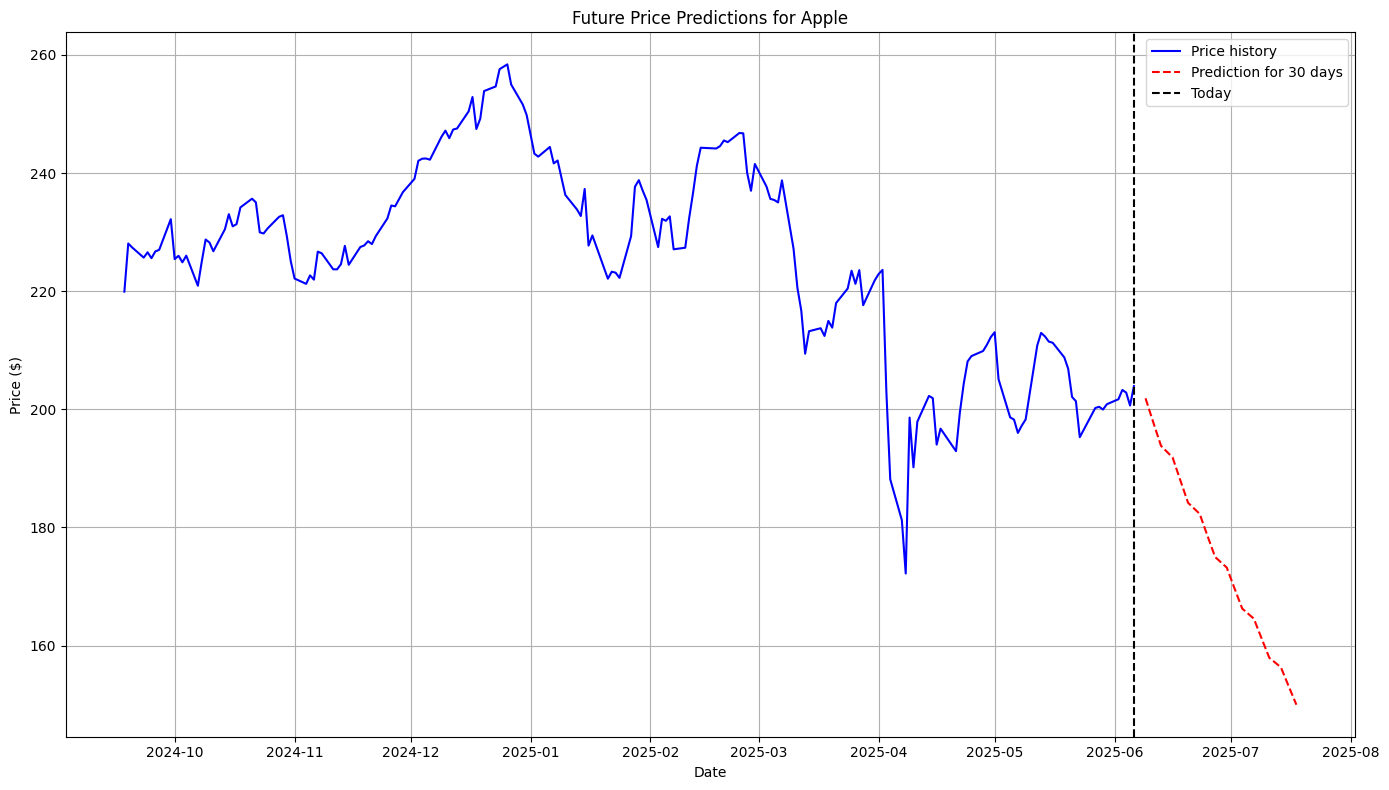

In [36]:
# Visualisation
plt.figure(figsize=(14, 8))

plt.plot(data_future.index[-180:], data_future['Price'].iloc[-180:], 'b-', label='Price history')

# Tracer les prédictions pour chaque horizon
colors = ['r', 'g', 'm', 'c', 'b']
for i, (horizon, (dates, prices)) in enumerate(predictions.items()):
    plt.plot(dates, prices, linestyle='--', 
             color=colors[i], label=f'Prediction for {horizon} days')

plt.axvline(x=data_future.index[-1], color='k', linestyle='--', label='Today')
plt.title('Future Price Predictions for Apple')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

___